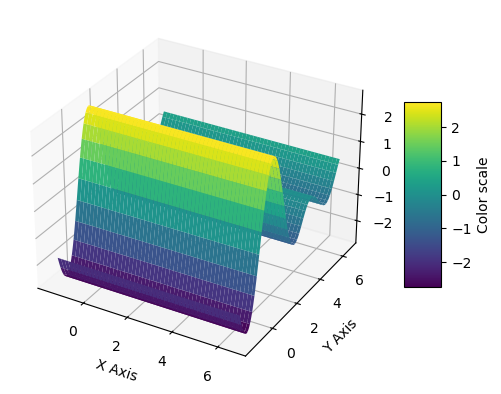

1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy


# function to regress:
def non_linear_func_orig(x, y):
    z = np.sin(x) + np.sin(1.5*y) + np.sin(2*x)
    return z

def non_linear_func(x, y):
    z = np.sin(x) + np.sin(1.5*y) + np.sin(2*x) + 0.15*np.random.randn(*x.shape) + 0.15*np.random.randn(*y.shape)
    return z

n_samples = 1000
seed = 42
np.random.seed(seed)

X = np.random.rand(n_samples,1) * 2.6*np.pi - np.pi/2
Y = np.random.rand(n_samples,1) * 2.6*np.pi - np.pi/2

Z = non_linear_func(X, Y)

x_orig = np.linspace(X.min(), X.max(), 200).reshape(200,1)
y_orig = np.linspace(X.min(), X.max(), 200).reshape(200,1)
z_orig = non_linear_func_orig(x_orig, y_orig)

x_plot, y_plot = np.meshgrid(x_orig, y_orig)

fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x_plot, y_plot, z_orig, cmap='viridis', edgecolor='none')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
color_bar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Color scale')
plt.show()

print(len(x_orig[0]))




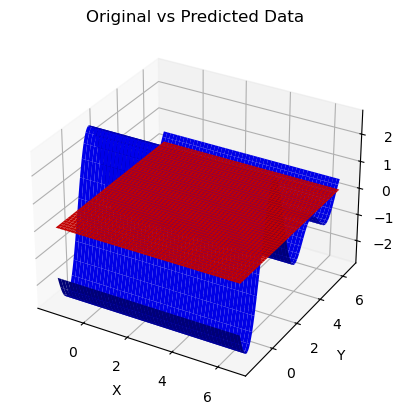

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the neural network architecture
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList() # initialize the layers list as an empty list using nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size)) # Add the first input layer. The layer takes as input <input_size> neurons and gets as output <hidden_size> neurons
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size)) # Add hidden layers
        self.layers.append(nn.Linear(hidden_size, output_size)) # add output layer

    def forward(self, x):    # Function to perform forward propagation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x


input_size = 2
num_layers = 10
hidden_size = 32
output_size = 1


# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x_orig, dtype=torch.float32)
y_tensor = torch.tensor(y_orig, dtype=torch.float32)
z_tensor = torch.tensor(z_orig, dtype=torch.float32)

# Combine x and y tensors into a single input tensor
input_tensor_first = torch.cat((x_tensor, y_tensor), dim=1)
model = MyNeuralNetwork(input_size, hidden_size, output_size, num_layers)

with torch.no_grad():
    z_pred_first = model(input_tensor_first).numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig, color='b', label='Original Data')
ax.plot_surface(x_plot, y_plot, z_pred_first, color='r', label='Predicted Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Original vs Predicted Data")
plt.show()


Epoch [100/1000], Loss: 0.9300, Test loss: 1.0218
Epoch [200/1000], Loss: 0.4727, Test loss: 0.4684
Epoch [300/1000], Loss: 0.3841, Test loss: 0.3605
Epoch [400/1000], Loss: 0.3689, Test loss: 0.3741
Epoch [500/1000], Loss: 0.2823, Test loss: 0.2686
Epoch [600/1000], Loss: 0.2553, Test loss: 0.2630
Epoch [700/1000], Loss: 0.2594, Test loss: 0.2892
Epoch [800/1000], Loss: 0.2518, Test loss: 0.2477
Epoch [900/1000], Loss: 0.2614, Test loss: 0.2529
Epoch [1000/1000], Loss: 0.2377, Test loss: 0.2384


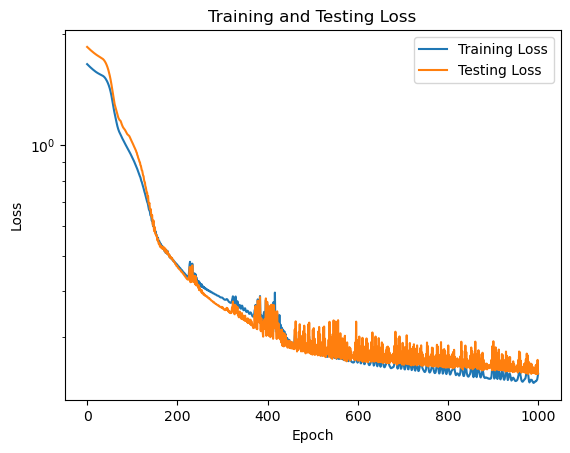

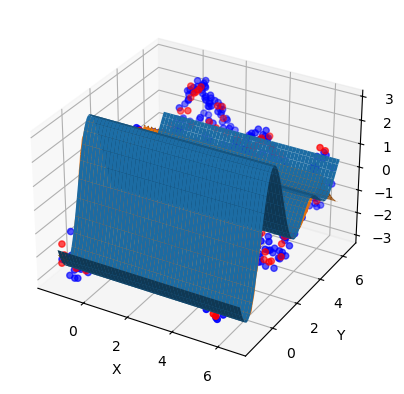

In [4]:
from sklearn.model_selection import train_test_split
# Split the training data into a new training set and a validation set
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X, Y, Z, test_size=0.2, random_state=42)

# Convert the variables to tensors so that they can be used in pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Z_train = torch.tensor(Z_train, dtype=torch.float32)
Z_test = torch.tensor(Z_test, dtype=torch.float32)


####################################################""

#step 2
#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters()) # here we are using the Adam optimizer, to optimize model.parameters, but what is there inside this attribute?


###########################################################

# step 3
# Lists to store training loss and testing loss
train_loss_list = []
test_loss_list = []

# Training loop
input_train = torch.cat((X_train, Y_train), dim=1)
input_test = torch.cat((X_test, Y_test), dim=1)
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    output = model(input_train)
    loss = criterion(output, Z_train)

    # Compute loss on testing data. NOTE: we aren't gonna use the test loss for optimization!!!
    output_test = model(input_test)
    loss_test = criterion(output_test, Z_test)

    # Backprop and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_list.append(loss.item()) # Save the losses
    test_loss_list.append(loss_test.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

# Plot training and testing loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.yscale('log')
plt.legend()
plt.show()

# Plot the NN performance:
with torch.no_grad():
    Z_pred = model(input_tensor_first)


fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(x_plot, y_plot, z_orig, label='Original surface')
ax3.scatter(X_test, Y_test, Z_test.numpy(), color='r', label='Testing')
ax3.scatter(X_train, Y_train, Z_train.numpy(), color='b', label='Testing')
ax3.plot_surface(x_plot, y_plot, Z_pred, label = 'Predicted surface')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
plt.show()

In [11]:
months = np.arange(1, 900)                    ## we have 899 dates in the data, each one for a month
nb_of_validation_months = 90                  ## we're doing the predictions on this time frame (so if 12 then we predict the temperatures of next year)
end_work = len(months)-nb_of_validation_months
nb_working_months = 200                       ## both training and testing data separated from validation months

start_work = end_work - nb_working_months     ## not all the datas are useful (1948 is pretty far in the past), also too much data makes it harder to train the model

## create the validation and work (train + test) datasets
working_months = np.linspace(0, nb_working_months-1, nb_working_months)
print(working_months)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 